# Lesson 6.3 正则化与sklearn逻辑回归参数详解

&emsp;&emsp;在了解了sklearn的一些常用的操作之后，接下来，我们来详细探讨关于正则化的相关内容，并就sklearn中的逻辑回归的参数进行详细解释。需要注意的是，由于sklearn内部参数的一致性，有许多参数不仅是逻辑回归的参数，更是大多数分类模型的通用参数。

In [1]:
# 科学计算模块
import numpy as np
import pandas as pd

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

## 四、过拟合、正则化、特征衍生与特征重要性评估

&emsp;&emsp;在上一小节中，我们已经尝试着利用逻辑回归构建了一个多分类模型，得益于sklearn中良好的默认参数设置，我们在对sklearn中内部构造基本没有任何了解的情况下就完成了相关模型的建模。但需要知道的事，逻辑回归作为一个诞生时间较早并且拥有深厚统计学背景的模型，其实是拥有非常多变种应用方法的，虽然我们在Lesson 4中就逻辑回归的基本原理、基础公式以及分类性能进行了较长时间的探讨，但实际上逻辑回归算法的模型形态和应用方式远不仅于此。而在sklearn中，则提供了非常丰富的逻辑回归的可选的算法参数，相当于是提供了一个集大成者的逻辑回归模型。

&emsp;&emsp;当然，首先我们需要介绍一个非常重要的机器学习中的概念，正则化。在逻辑回归的说明文档中，第一个参数就是关于正则化的一个选项：

In [1]:
from sklearn.linear_model import LogisticRegression

In [3]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

也就是penalty='l2'一项，而正则化也是机器学习中非常通用的一项操作。接下来，我们就正则化的相关内容展开讨论。

### 1.正则化（Regularization）的基本概念

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gs3v9h2gysj31gi0sy7bh.jpg" alt="1" style="zoom:33%;" />

&emsp;&emsp;从说明文档中得知，就是在sklearn中，逻辑回归模型是默认进行正则化的，即上文所述“Regularization is applied by default”，这是一种在机器学习建模过程中常见的用法，但并非统计学常用方法。据此我们也知道了统计学和机器学习方法之间的又一个区别，并且能够清楚的感受到sklearn是一个非常“机器学习”的算法库，很多时候会从便于机器学习建模的角度出发对算法进行微调，而这也是sklearn算法库的一大特性，这个特性在导致其非常易用的同时，也使得其很多算法和原始提出的算法会存在略微的区别，这点也是初学者需要注意的。

- 什么是正则化/如何进行正则化

&emsp;&emsp;其实机器学习中正则化（regularization）的外在形式非常简单，就是在模型的损失函数中加上一个正则化项（regularizer），有时也被称为惩罚项（penalty term），如下方程所示，其中L为损失函数，J为正则化项。通常来说，正则化项往往是关于模型参数的1-范数或者2-范数，当然也有可能是这两者的某种结合，例如sklearn的逻辑回归中的弹性网正则化项，其中加入模型参数的1-范数的正则化也被称为$l1$正则化，加入模型参数的2-范数的正则化也被称为$l2$正则化。

$$\frac{1}{N}\sum^{N}_{i=1}L(y_i,f(x_i))+\lambda J{(f)}$$

- 为何需要正则化

&emsp;&emsp;正则化的过程比不复杂，但何时需要进行正则化呢？

&emsp;&emsp;一般来说，正则化核心的作用是缓解模型过拟合倾向，此外，由于加入正则化项后损失函数的形体发生了变化，因此也会影响损失函数的求解过程，在某些时候，加入了正则化项之后会让损失函数的求解变得更加高效。如此前介绍的岭回归，其实就是在线性回归的损失函数基础上加入了w的1-范数，而Lasso则是加入了w的2-范数。并且，对于逻辑回归来说，如果加入$l2$正则化项，损失函数就会变成严格的凸函数。

- 经验风险与结构风险

&emsp;&emsp;要讨论正则化是如何缓解过拟合倾向的问题，需要引入两个非常重要的概念：经验风险和结构风险。

&emsp;&emsp;在我们构建损失函数求最小值的过程，其实就是依据以往经验（也就是训练数据）追求风险最小（以往数据误差最小）的过程，而在给定一组参数后计算得出的损失函数的损失值，其实就是经验风险。而所谓结构风险，我们可以将其等价为模型复杂程度，模型越复杂，模型结构风险就越大。而正则化后的损失函数在进行最小值求解的过程中，其实是希望损失函数本身和正则化项都取得较小的值，即模型的经验风险和结构风险能够同时得到控制。

&emsp;&emsp;模型的经验风险需要被控制不难理解，因为我们希望模型能够尽可能的捕捉原始数据中的规律，但为何模型的结构风险也需要被控制？核心原因在于，尽管在一定范围内模型复杂度增加能够有效提升模型性能，但模型过于复杂可能会导致另一个非常常见的问题——模型过拟合，关于模型过拟合的概念我们稍后会进行更加详细的介绍，但总的来说，一旦模型过拟合了，尽管模型经验风险在降低、但模型的泛化能力会下降。因此，为了控制模型过拟合倾向，我们可以把模型结构风险纳入损失函数中一并考虑，当模型结构风险的增速高于损失值降低的收益时，我们就需要停止参数训练（迭代）。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gs3wqah1w2j30pu0iaadu.jpg" alt="1" style="zoom:33%;" />

> 同时要求模型性能和模型复杂度都在一个合理的范围内，其实等价于希望训练得到一个较小的模型同时具有较好的解释数据的能力（规律捕捉能力），这也符合奥卡姆剃刀原则。

### 2.过拟合概念介绍

&emsp;&emsp;此前我们曾深入探讨过关于机器学习建模有效性的问题，彼时我们得出的结论是当训练数据和新数据具有规律的一致性时，才能够进行建模，而只有挖掘出贯穿始终的规律（同时影响训练数据和新数据的规律），模型才能够进行有效预测。不过，既然有些贯穿始终的全局规律，那就肯定存在一些只影响了一部分数据的局部规律。一般来说，由于全局规律影响数据较多，因此更容易被挖掘，而局部规律只影响部分数据，因此更难被挖掘，因此从较为宽泛的角度来看，但伴随着模型性能提升，也是能够捕获很多局部规律的。但是需要知道的是，局部规律对于新数据的预测并不能起到正面的作用，反而会影响预测结果，此时就出现模型过拟合现象。我们可以通过如下实例进行说明：

In [117]:
# 设计随机数种子
np.random.seed(123)

# 创建数据
n_dots = 20
x = np.linspace(0, 1, n_dots)                        # 从0到1，等宽排布的20个数
y = np.sqrt(x) + 0.2*np.random.rand(n_dots) - 0.1    

In [118]:
x

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [119]:
y

array([0.03929384, 0.1866436 , 0.26981313, 0.40762266, 0.50272526,
       0.49761047, 0.65810433, 0.64394293, 0.64507206, 0.66667071,
       0.69411185, 0.80669585, 0.78243386, 0.73910577, 0.83800393,
       0.9361224 , 0.85416128, 0.88099565, 0.9796388 , 1.00636552])

其中，x是一个0到1之间等距分布20个点组成的ndarray，$y=\sqrt{x}+r$，其中r是人为制造的随机噪声，在[-0.1,0.1]之间服从均匀分布。然后我们借助numpy的polyfit函数来进行多项式拟合，polyfit函数会根据设置的多项式阶数，在给定数据的基础上利用最小二乘法进行拟合，并返回拟合后各阶系数。该函数更多相关参数详见[numpy.polynomial.polynomial.polyfit](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polynomial.polynomial.polyfit.html)官网API讲解。同时，当系数计算完成后，我们还常用ploy1d函数逆向构造多项式方程，进而利用方程求解y，该函数用法参见[numpy.poly1d](https://docs.scipy.org/doc/numpy/reference/generated/numpy.poly1d.html)官网说明。

例如人为制造一个二阶多项式方程然后进行二阶拟合实验

In [29]:
y0 = x ** 2
np.polyfit(x, y0, 2)

array([1.00000000e+00, 4.16603364e-17, 1.85278864e-17])

能够得出多项式各阶系数，而根据该系数可用ploy1d逆向构造多项式方程

In [30]:
p = np.poly1d(np.polyfit(x, y0, 2))
print(p)

   2
1 x + 4.166e-17 x + 1.853e-17


能够看到多项式结构基本和原多项式保持一致，此时生成的p对象相当于是一个多项式方程，可通计算输入参数的多项式输出结果

In [31]:
p(-1)

0.9999999999999998

In [32]:
np.poly1d(np.polyfit(x, y, 3))

poly1d([ 1.90995297, -3.61611811,  2.6742144 ,  0.04912333])

接下来，进行多项式拟合。分别利用1阶x多项式、3阶x多项式和10阶x多项式来拟合y。并利用图形观察多项式的拟合度，首先我们可定义一个辅助画图函数，方便后续我们将图形画于一张画布中，进而方便观察

In [33]:
def plot_polynomial_fit(x, y, deg):
    p = np.poly1d(np.polyfit(x, y, deg))
    t = np.linspace(0, 1, 200)
    plt.plot(x, y, 'ro', t, p(t), '-', t, np.sqrt(t), 'r--')

其中，t为[0,1]中等距分布的100个点，而p是deg参数决定的多项式回归拟合方程，p(t)即为拟合方程x输入t值时多项式输出结果，此处plot_polynomial_fit函数用于生成同时包含（x，y）原始值组成的红色点图、（t，p(t)）组成的默认颜色的曲线图、（t，np.sqrt(t)）构成的红色虚线曲线图。测试3阶多项式拟合结果

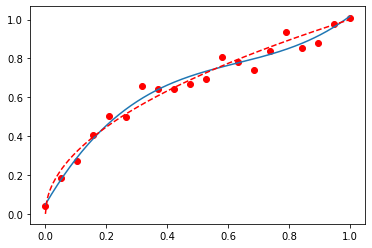

In [34]:
plot_polynomial_fit(x, y, 3)

这里需要注意(x,y)组成的红色点图相当于带有噪声的二维空间数据分布，(t, p(t))构成的蓝色曲线相当于3阶多项式拟合原数据集（(x, y)数据集）后的结果，而原始数据集包含的客观规律实际上是$y=\sqrt{x}$，因此最后红色的虚线（t, np.sqrt(t)）实际上是代表红色点集背后的客观规律，即我们希望拟合多项式（蓝色曲线）能够尽可能的拟合代表客观规律的红色虚线，而不是被噪声数据所吸引偏离红色虚线位置，同时也不希望完全没有捕捉到红色曲线的规律。接下来，我们尝试将1阶拟合、3阶拟合和10阶拟合绘制在一张图中。

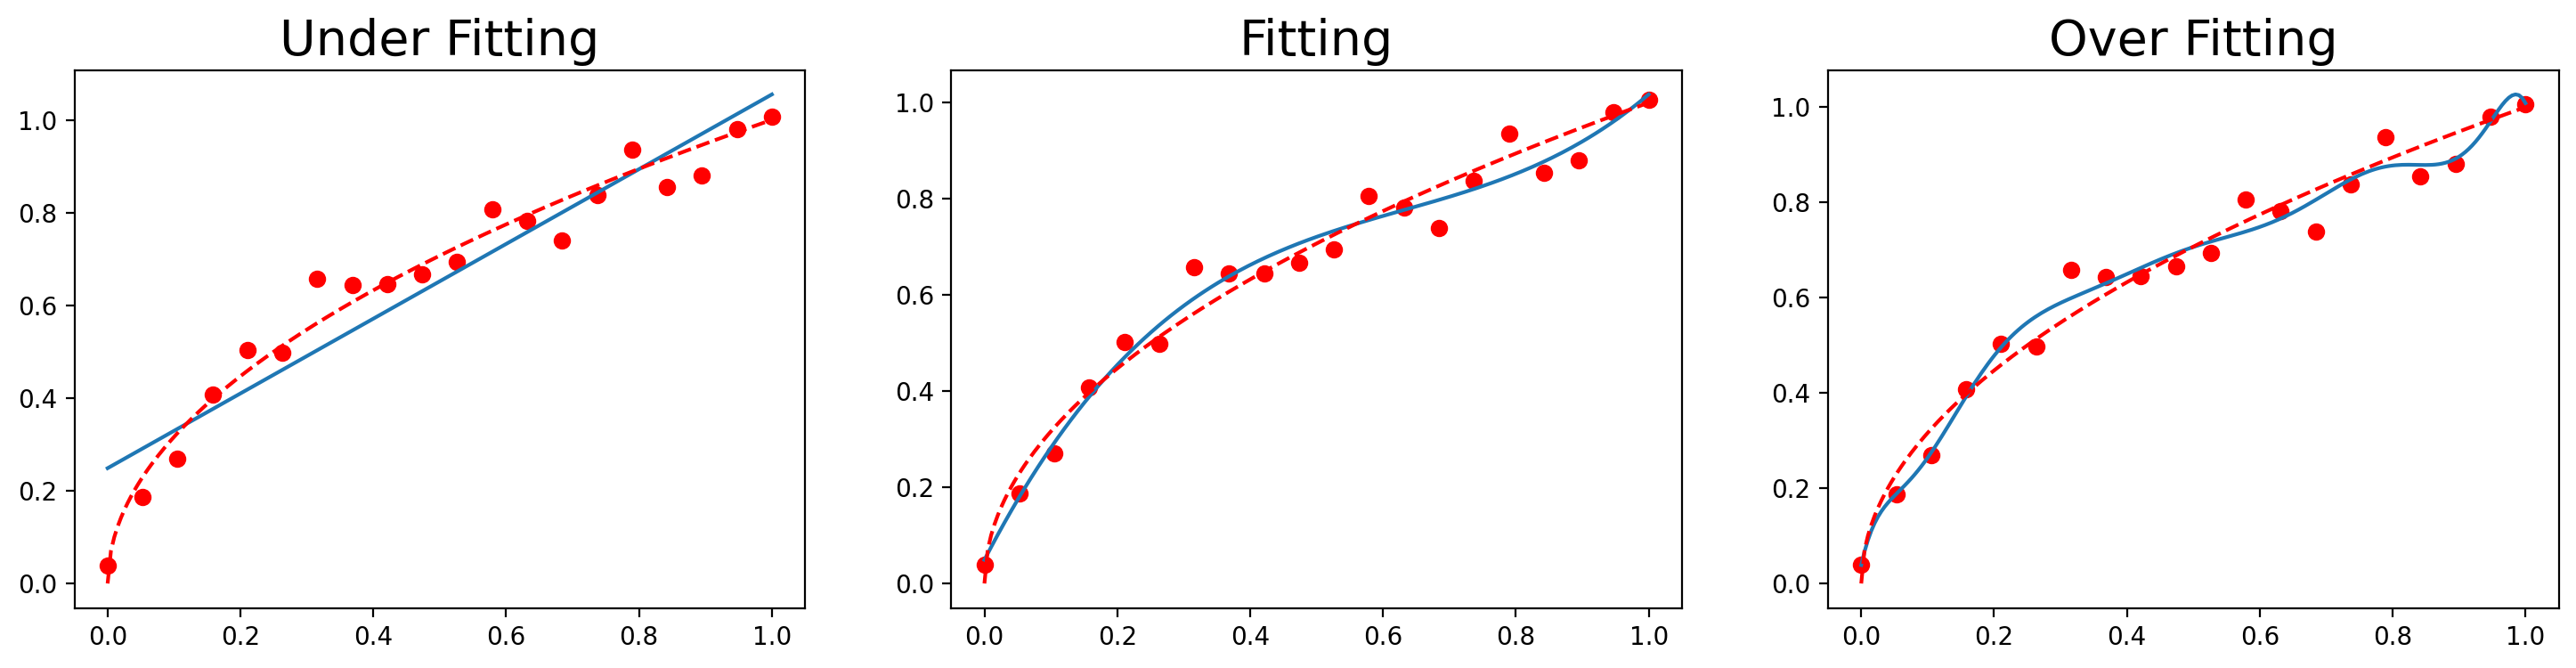

In [35]:
plt.figure(figsize=(18, 4), dpi=200)
titles = ['Under Fitting', 'Fitting', 'Over Fitting']
for index, deg in enumerate([1, 3, 10]):
    plt.subplot(1, 3, index + 1)
    plot_polynomial_fit(x, y, deg)
    plt.title(titles[index], fontsize=20)

&emsp;&emsp;根据最终的输出结果我们能够清楚的看到，1阶多项式拟合的时候蓝色拟合曲线即无法捕捉数据集的分布规律，离数据集背后客观规律也很远，而三阶多项式在这两方面表现良好，十阶多项式则在数据集分布规律捕捉上表现良好，单同样偏离红色曲线较远。此时一阶多项式实际上就是欠拟合，而十阶多项式则过分捕捉噪声数据的分布规律，而噪声之所以被称作噪声，是因为其分布本身毫无规律可言，或者其分布规律毫无价值（如此处噪声分布为均匀分布），因此就算十阶多项式在当前训练数据集上拟合度很高，但其捕捉到的无用规律无法推广到新的数据集上，因此该模型在测试数据集上执行过程将会有很大误差。即模型训练误差很小，但泛化误差很大。

### 3.正则化进行特征筛选与缓解过拟合倾向

&emsp;&emsp;接下来，我们尝试如何通过在模型中加入正则化项来缓解10阶多项式回归的过拟合倾向。

&emsp;&emsp;为了更加符合sklearn的建模风格、从而能够使用sklearn的诸多方法，我们将上述10阶多项式建模转化为一个等价的形式，即在原始数据中衍生出几个特征，分别是$x^2$、$x^3$、...、$x^{10}$，然后带入线性回归方程进行建模

In [36]:
x_l = []

In [37]:
for i in range(10):
    x_temp = np.power(x, i+1).reshape(-1, 1)
    x_l.append(x_temp)

In [38]:
X = np.concatenate(x_l, 1)

In [39]:
X[:2]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [5.26315789e-02, 2.77008310e-03, 1.45793847e-04, 7.67336039e-06,
        4.03861073e-07, 2.12558460e-08, 1.11872874e-09, 5.88804597e-11,
        3.09897157e-12, 1.63103767e-13]])

In [40]:
y

array([0.03929384, 0.1866436 , 0.26981313, 0.40762266, 0.50272526,
       0.49761047, 0.65810433, 0.64394293, 0.64507206, 0.66667071,
       0.69411185, 0.80669585, 0.78243386, 0.73910577, 0.83800393,
       0.9361224 , 0.85416128, 0.88099565, 0.9796388 , 1.00636552])

&emsp;&emsp;当然，上述过程其实也就是比较简单的一种特征衍生方法，该方法也可以通过sklearn中的PolynomialFeatures类来进行实现。

In [41]:
from sklearn.preprocessing import PolynomialFeatures

In [42]:
# 查看帮助文档
PolynomialFeatures?

Init signature:
PolynomialFeatures(
    degree=2,
    *,
    interaction_only=False,
    include_bias=True,
    order='C',
)
Docstring:     
Generate polynomial and interaction features.

Generate a new feature matrix consisting of all polynomial combinations
of the features with degree less than or equal to the specified degree.
For example, if an input sample is two dimensional and of the form
[a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

Parameters
----------
degree : integer
    The degree of the polynomial features. Default = 2.

interaction_only : boolean, default = False
    If true, only interaction features are produced: features that are
    products of at most ``degree`` *distinct* input features (so not
    ``x[1] ** 2``, ``x[0] * x[2] ** 3``, etc.).

include_bias : boolean
    If True (default), then include a bias column, the feature in which
    all polynomial powers are zero (i.e. a column of ones - acts as an
    intercept term in a linear mode

对其参数进行解释：

|Name|Description|      
|:--:|:--:|      
|degree|最高阶数|      
|interaction_only|是否只包含交叉项，交叉项指的是不同特征的乘结果|
|include_bias|是否只包含0阶计算结果、偏置项|
|计算模式|默认C模式，F模式能提高单独评估器计算效率，但会影响机器学习流中其他评估器|

In [43]:
x.reshape(-1, 1)[:2]

array([[0.        ],
       [0.05263158]])

In [44]:
# 二阶特征衍生
PolynomialFeatures(degree=2).fit_transform(x.reshape(-1, 1))[:2]

array([[1.        , 0.        , 0.        ],
       [1.        , 0.05263158, 0.00277008]])

In [78]:
# 二阶特征衍生只包含交叉项
PolynomialFeatures(degree=2, interaction_only=True).fit_transform(x.reshape(-1, 1))[:2]

array([[1.        , 0.        ],
       [1.        , 0.05263158]])

In [46]:
poly = PolynomialFeatures(degree = 10, include_bias=False)

In [81]:
poly.fit_transform(x.reshape(-1, 1))[:2]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [5.26315789e-02, 2.77008310e-03, 1.45793847e-04, 7.67336039e-06,
        4.03861073e-07, 2.12558460e-08, 1.11872874e-09, 5.88804597e-11,
        3.09897157e-12, 1.63103767e-13]])

接下来，围绕特征衍生后的新数据来进行线性回归建模。

In [50]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)

In [53]:
lr.coef_

array([ 6.26103457e+00, -1.19764265e+02,  1.42603456e+03, -8.87839988e+03,
        3.20918671e+04, -7.14049022e+04,  9.93100740e+04, -8.41213555e+04,
        3.96752034e+04, -7.98404881e+03])

In [54]:
# 查看过拟合时MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(lr.predict(X), y)

0.001172668222879593

Text(0.5, 1.0, '10-degree')

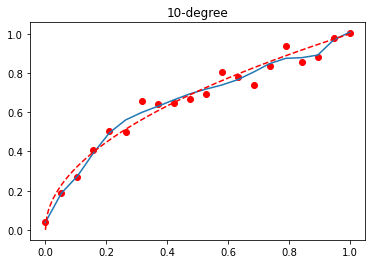

In [86]:
# 观察建模结果
t = np.linspace(0, 1, 200)
plt.plot(x, y, 'ro', x, lr.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('10-degree')

&emsp;&emsp;接下来，我们尝试在线性回归的损失函数中引入正则化，来缓解10阶特征衍生后的过拟合问题。根据Lesson 3.3的讨论我们知道，在线性回归中加入l2正则化，实际上就是岭回归（Ridge），而加入l1正则化，则变成了Lasso。因此，我们分别考虑围绕上述模型进行岭回归和Lasso的建模。

In [57]:
# 导入岭回归和Lasso
from sklearn.linear_model import Ridge,Lasso

<img src="https://tva1.sinaimg.cn/large/008i3skNly1gs57fo7i2zj31hs0d2mzx.jpg" alt="1" style="zoom:40%;" />

In [58]:
Ridge?

Init signature:
Ridge(
    alpha=1.0,
    *,
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    max_iter=None,
    tol=0.001,
    solver='auto',
    random_state=None,
)
Docstring:     
Linear least squares with l2 regularization.

Minimizes the objective function::

||y - Xw||^2_2 + alpha * ||w||^2_2

This model solves a regression model where the loss function is
the linear least squares function and regularization is given by
the l2-norm. Also known as Ridge Regression or Tikhonov regularization.
This estimator has built-in support for multi-variate regression
(i.e., when y is a 2d-array of shape (n_samples, n_targets)).

Read more in the :ref:`User Guide <ridge_regression>`.

Parameters
----------
alpha : {float, ndarray of shape (n_targets,)}, default=1.0
    Regularization strength; must be a positive float. Regularization
    improves the conditioning of the problem and reduces the variance of
    the estimates. Larger values specify stronger regularization.
    A

In [59]:
# 参数越多、模型越简单、相同的alpha惩罚力度越大
reg_rid = Ridge(alpha=0.005)

In [60]:
reg_rid.fit(X, y)

Ridge(alpha=0.005)

In [61]:
reg_rid.coef_

array([ 1.69951452e+00, -7.27654755e-01, -5.16601900e-01, -9.16814563e-02,
        1.44069563e-01,  2.10532895e-01,  1.77803630e-01,  9.77891137e-02,
        9.12868410e-04, -9.69907721e-02])

In [90]:
mean_squared_error(reg_rid.predict(X), y)

0.0021197020660901986

Text(0.5, 1.0, 'LinearRegression')

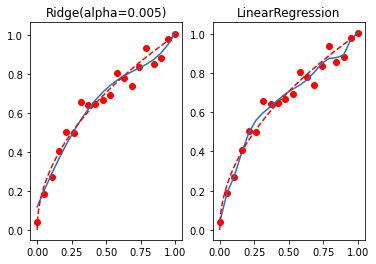

In [87]:
# 观察惩罚效果
t = np.linspace(0, 1, 200)
plt.subplot(121)
plt.plot(x, y, 'ro', x, reg_rid.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('Ridge(alpha=0.005)')
plt.subplot(122)
plt.plot(x, y, 'ro', x, lr.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('LinearRegression')

不难发现，l2正则化对过拟合倾向有较为明显的抑制作用。接下来尝试Lasso

In [183]:
Lasso?

Init signature:
Lasso(
    alpha=1.0,
    *,
    fit_intercept=True,
    normalize=False,
    precompute=False,
    copy_X=True,
    max_iter=1000,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None,
    selection='cyclic',
)
Docstring:     
Linear Model trained with L1 prior as regularizer (aka the Lasso)

The optimization objective for Lasso is::

    (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Technically the Lasso model is optimizing the same objective function as
the Elastic Net with ``l1_ratio=1.0`` (no L2 penalty).

Read more in the :ref:`User Guide <lasso>`.

Parameters
----------
alpha : float, default=1.0
    Constant that multiplies the L1 term. Defaults to 1.0.
    ``alpha = 0`` is equivalent to an ordinary least square, solved
    by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
    Given this, you should use the :class:`LinearRegression` object.

fit

<img src="https://tva1.sinaimg.cn/large/008i3skNly1gs57jwdrsnj31go0j4n22.jpg" alt="1" style="zoom:40%;" />

In [64]:
reg_las = Lasso(alpha=0.001)

In [65]:
reg_las.fit(X, y)

Lasso(alpha=0.001)

In [66]:
reg_las.coef_

array([ 1.10845364, -0.        , -0.37211179, -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.05080217])

In [92]:
mean_squared_error(reg_las.predict(X), y)

0.004002917874293844

Text(0.5, 1.0, 'LinearRegression')

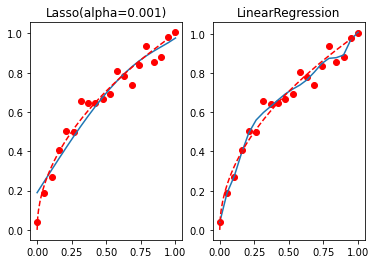

In [93]:
t = np.linspace(0, 1, 200)
plt.subplot(121)
plt.plot(x, y, 'ro', x, reg_las.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('Lasso(alpha=0.001)')
plt.subplot(122)
plt.plot(x, y, 'ro', x, lr.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('LinearRegression')

&emsp;&emsp;我们发现，Lasso的惩罚力度更强，并且迅速将一些参数清零，而这些被清零的参数，则代表对应的参数在实际建模过程中并不重要，从而达到特种重要性筛选的目的。而在实际的建模过程中，l2正则化往往应用于缓解过拟合趋势，而l1正则化往往被用于特征筛选的场景中。

> 其实特征重要性和（线性方程中）特征对应系数大小并没有太大的关系，判断特种是否重要的核心还是在于观察抛弃某些特征后，建模结果是否会发生显著影响。

&emsp;&emsp;有上述过程，我们不难发现，l2缓解过拟合效果更好（相比l1正则化，l2正则化在参数筛选时过程更容易控制），而l1正则化的运算结果说明，上述10个特征中，第一个、第三个和最后一个特征相对重要。而特征重要的含义，其实是代表哪怕带入上述3个特征建模，依然能够达到带入所有特征建模的效果。我们可以通过下述实验进行验证：

In [70]:
# 挑选特征，构建新的特征矩阵
X_af = X[:, [0, 2, 9]]

In [71]:
lr_af = LinearRegression()

In [72]:
lr_af.fit(X_af, y)

LinearRegression()

In [73]:
lr_af.coef_

array([ 1.45261658, -0.93936141,  0.39449483])

In [74]:
mean_squared_error(lr_af.predict(X_af), y)

0.0027510973386944155

In [75]:
lr_af.predict(X_af)

array([0.12785414, 0.2041707 , 0.27966553, 0.35351693, 0.42490323,
       0.49300315, 0.55699719, 0.61607193, 0.66943127, 0.71632121,
       0.75607951, 0.788227  , 0.8126252 , 0.82973402, 0.84101554,
       0.84954371, 0.86089679, 0.88442936, 0.93504335, 1.03560415])

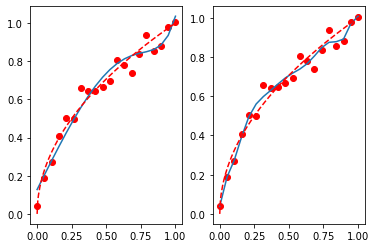

In [76]:
t = np.linspace(0, 1, 200)
plt.subplot(121)
plt.plot(x, y, 'ro', x, lr_af.predict(X_af), '-', t, np.sqrt(t), 'r--')
plt.subplot(122)
plt.plot(x, y, 'ro', x, lr.predict(X), '-', t, np.sqrt(t), 'r--')

&emsp;&emsp;我们发现，哪怕删掉了70%的特征，最终建模结果仍然还是未收到太大的影响，从侧面也说明剩下70%的特征确实“不太重要”。当然，在删除这些数据之后，模型过拟合的趋势略微有所好转，那如果我们继续加上l2正则化呢？会不会有更好防止过拟合的效果？

In [111]:
# 特征减少，可以适度放大alpha
reg_rid_af = Ridge(alpha=0.05)

In [112]:
reg_rid_af.fit(X_af, y)

Ridge(alpha=0.05)

In [113]:
reg_rid_af.coef_

array([ 1.02815296, -0.31070552,  0.06374435])

In [114]:
mean_squared_error(reg_rid_af.predict(X_af), y)

0.004383156990375146

Text(0.5, 1.0, 'Ridge(alpha=0.005)')

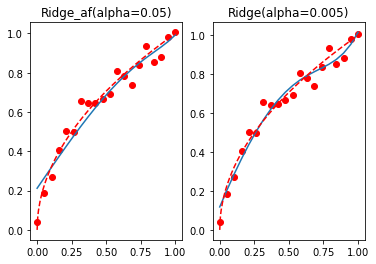

In [116]:
t = np.linspace(0, 1, 200)
plt.subplot(121)
plt.plot(x, y, 'ro', x, reg_rid_af.predict(X_af), '-', t, np.sqrt(t), 'r--')
plt.title('Ridge_af(alpha=0.05)')
plt.subplot(122)
plt.plot(x, y, 'ro', x, reg_rid.predict(X), '-', t, np.sqrt(t), 'r--')
plt.title('Ridge(alpha=0.005)')

&emsp;&emsp;不难发现，模型整体过拟合倾向被更进一步抑制，整体拟合效果较好。

&emsp;&emsp;此处虽然重点介绍关于l1正则化和l2正则化对模型过拟合效果抑制的效果，但实际上，从上述过程中，我们其实能够总结一套建模策略：

- 当模型效果（往往是线性模型）不佳时，可以考虑通过特征衍生的方式来进行数据的“增强”；
- 如果出现过拟合趋势，则首先可以考虑进行不重要特征的筛选，过多的无关特征其实也会影响模型对于全局规律的判断，当然此时可以考虑使用l1正则化配合线性方程进行特征重要性筛选，剔除不重要的特征，保留重要特征；
- 对于过拟合趋势的抑制，仅仅踢出不重要特征还是不够的，对于线性方程类的模型来说，l2正则化则是缓解过拟合非常好的方法，配合特征筛选，能够快速的缓解模型过拟合倾向；

&emsp;&emsp;当然，除此以外，还有一些注意事项：

- 首先，哪怕不进行特征筛选，l2正则化也可以帮助线性方程抑制过拟合，但特征太多其实会影响l2正则化的参数取值范围，进而影响alpha参数惩罚力度的有效性；
- 其次，上述参数的选取和过拟合倾向的判断，其实还是主观判断成分较多，一个更加严谨的流程是，先进行数据集的划分，然后选取更能表示模型泛化能力的评估指标，然后将特征提取（如果要做的话）、l2正则化后的线性方程组成一个Pipeline，再利用网格搜索，确定一组最优的参数组合。相关方法我们会在下一小节进行介绍。
- 最后，需要强调的是，并非所有模型都需要/可以通过正则化来进行过拟合修正，典型的可以通过正则化来进行过拟合倾向修正的模型主要有线性回归、逻辑回归、LDA、SVM以及一些PCA衍生算法（如SparsePCA）。而树模型则不用通过正则化来进行过拟合修正。

## 五、sklearn中逻辑回归的参数解释

&emsp;&emsp;在补充了关于正则化的相关内容之后，接下来，我们来详细讨论关于逻辑回归的参数解释。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gs3v9h2gysj31gi0sy7bh.jpg" alt="1" style="zoom:33%;" />

### 1.说明文档中的内容解释

&emsp;&emsp;首先，先对上述逻辑回归的说明文档中的内容进行解释。

- sklearn中逻辑回归损失函数形态

&emsp;&emsp;在了解了正则化的相关内容后，接下来我们观察sklearn官网中给出的逻辑回归加入正则化后的损失函数表达式，我们发现该表达式和此前我们推到的交叉熵损失函数的表达式还是略有差异，核心原因是sklearn在二分类的时候默认两个类别的标签取值为-1和1，而不是0和1。我们曾在Lesson 4.2中进行了非常详细的关于逻辑回归损失函数的推导，此处的数学推导，我们只需将Lesson 4.2中公式当中的y的取值改为-1和1即可，相关推导过程留作课后习练习。

- 正则化后损失函数表达式

&emsp;&emsp;相比原始损失函数，正则化后的损失函数有两处发生了变化，其一是在原损失函数基础上乘以了系数C，其二则是加入了正则化项。其中系数C也是超参数，需要人工输入，用于调整经验风险部分和结构风险部分的权重，C越大，经验风险部分权重越大，反之结构风险部分权重越大。此外，在$l2$正则化时，采用的$\frac{w^Tw}{2}$表达式，其实相当于是各参数的平方和除以2，在求最小值时本质上和w的2-范数起到的作用相同，省去开平方是为了简化运算，而除以2则是为了方便后续求导运算，和2次方结果相消。

&emsp;&emsp;另外，sklearn中还提供了弹性网正则化方法，其实是通过$\rho$控制$l1$正则化和$l2$正则化惩罚力度的权重，是一个更加综合的解决方案。不过代价是增加了一个超参数$\rho$，并且由于损失函数形态发生了变化，导致部分优化方法无法使用。

### 2.sklearn中逻辑回归评估器的参数解释

&emsp;&emsp;在上述的一系列基础内容铺垫之后，接下来我们对逻辑回归评估器中的参数进行详细解释：

In [23]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

|参数|解释|
|:--:|:--:|    
|penalty|正则化项|   
|dual|是否求解对偶问题*|
|tol|迭代停止条件：两轮迭代损失值差值小于tol时，停止迭代|
|C|经验风险和结构风险在损失函数中的权重|
|fit_intercept|线性方程中是否包含截距项|
|intercept_scaling|相当于此前讨论的特征最后一列全为1的列，当使用liblinear求解参数时用于捕获截距|
|class_weight|各类样本权重*|
|random_state|随机数种子|
|solver|损失函数求解方法*|
|max_iter|求解参数时最大迭代次数，迭代过程满足max_iter或tol其一即停止迭代|
|multi_class|多分类问题时求解方法*|
|verbose|是否输出任务进程|
|warm_start|是否使用上次训练结果作为本次运行初始参数|
|l1_ratio|当采用弹性网正则化时，$l1$正则项权重，就是损失函数中的$\rho$|

- dual：是否求解对偶问题

&emsp;&emsp;对偶问题是约束条件相反、求解方向也相反的问题，当数据集过小而特征较多时，求解对偶问题能一定程度降低运算复杂度，其他情况建议保留默认参数取值。

- class_weight:各类样本权重

&emsp;&emsp;class_weight其实代表各类样本在进行损失函数计算时的数值权重，例如假设一个二分类问题，0、1两类的样本比例是2:1，此时可以输入一个字典类型对象用于说明两类样本在进行损失值计算时的权重，例如输入:{0:1, 1:3}，则代表1类样本的每一条数据在进行损失函数值的计算时都会在原始数值上*3。而当我们将该参数选为`balanced`时，则会自动将这个比例调整为真实样本比例的反比，以达到平衡的效果。

- solver：损失函数求解方法

&emsp;&emsp;其实除了最小二乘法和梯度下降以外，还有非常多的关于损失函数的求解方法，而选择损失函数的参数，就是solver参数。

&emsp;&emsp;而当前损失函数到底采用何种优化方法进行求解，其实最终目的是希望能够更快（计算效率更高）更好（准确性更高）的来进行求解，而硬性的约束条件是损失函数的形态，此外则是用户自行选择的空间。

&emsp;&emsp;我们很难一次性将所有的优化方法一次性介绍完整，但我们可以给出何时应该用哪种solver的参考列表，也就是官网给出的列表：

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gs5dfa4trbj31580ew47m.jpg" alt="1" style="zoom:33%;" />

&emsp;&emsp;逻辑回归可选的优化方法包括：        
&emsp;&emsp;liblinear，这是一种坐标轴下降法，并且该软件包中大多数算法都有C++编写，运行速度很快，支持OVR+L1或OVR+L2；      
&emsp;&emsp;lbfgs，全称是L-BFGS，牛顿法的一种改进算法（一种拟牛顿法），适用于小型数据集，并且支持MVM+L2、OVR+L2以及不带惩罚项的情况；      
&emsp;&emsp;newton-cg，同样也是一种拟牛顿法，和lbfgs适用情况相同；      
&emsp;&emsp;sag，随机平均梯度下降，随机梯度下降的改进版，类似动量法，会在下一轮随机梯度下降开始之前保留一些上一轮的梯度，从而为整个迭代过程增加惯性，除了不支持L1正则化的损失函数求解以外（包括弹性网正则化）其他所有损失函数的求解；      
&emsp;&emsp;saga，sag的改进版，修改了梯度惯性的计算方法，使得其支持所有情况下逻辑回归的损失函数求解；

&emsp;&emsp;对于逻辑回归来说，求解损失函数的硬性约束其实就是多分类问题时采用的策略以及加入的惩罚项，所以大多数情况，我们会优先根据多分类问题的策略及惩项来选取优化算法，其次，如果有多个算法可选，那么我们可以根据其他情况来进行求解器的选取，如：

&emsp;&emsp;Penalize the intercept (bad)，如果要对截距项也进行惩罚，那只能选取liblinear；      
&emsp;&emsp;Faster for large datasets，如果需要对海量数据进行快速处理，则可以选取sag和saga；      
&emsp;&emsp;Robust to unscaled datasets，如果未对数据集进行标准化，但希望维持数据集的鲁棒性（迭代平稳高效），则可以考虑使用liblinear、lbfgs和newton-cg三种求解方法。

- multi_class：选用何种方法进行多分类问题求解

&emsp;&emsp;可选OVR和MVM，当然默认情况是auto，此时模型会优先根据惩罚项和solver选择OVR还是MVM，但一般来说，MVM效果会好于OVR。

&emsp;&emsp;至此，我们即完成逻辑回归所有参数的解释，当然对于这些参数更深层次的理解，则需要长期的积淀、以及其他知识的补充。下一小节，也是Lesson 6的最后一小节，我们将利用sklearn中的逻辑回归、结合此前介绍的正则化相关内容，来进行一次综合调参练习。深化正则化方法使用情况的理解、同时进一步介绍sklearn中另一个至关重要的方法——网格搜索。